**Pre-Processing the image**

In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from imutils.object_detection import non_max_suppression

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
detector = '/content/frozen_east_text_detection.pb'
width,height = 320,320
image = cv2.imread('/content/cup.jpg')
min_confidence = 0.9


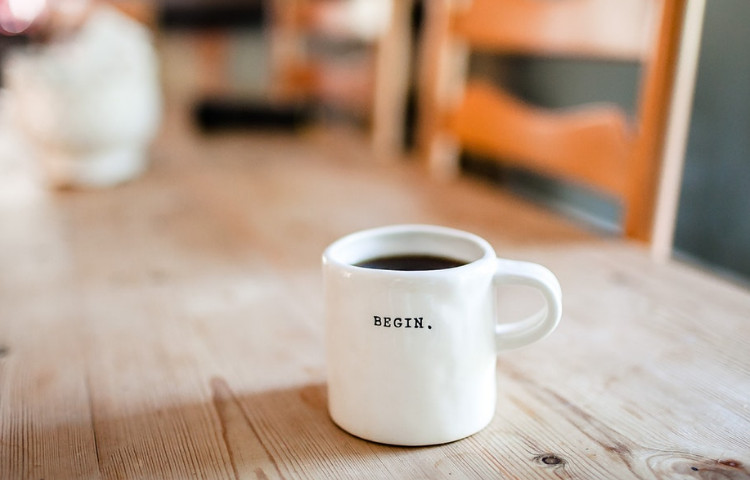

In [4]:
cv2_imshow(image)

In [5]:
original = image.copy()
image.shape

(480, 750, 3)

In [6]:
H = image.shape[0]
W = image.shape[1]
proprtion_w = W/float(width)
proprtion_h = H/float(height)
print(proprtion_h,proprtion_w)


1.5 2.34375


320 320


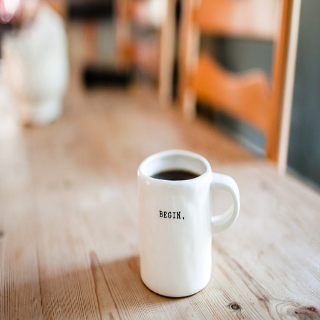

In [7]:
img = cv2.resize(image,(width,height))
H = img.shape[0]
W = img.shape[1]
print(H,W)
cv2_imshow(img)

In [8]:
!mkdir tessdata
!wget -O ./tessdata/eng.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/eng.traineddata?raw=true

--2025-08-28 10:19:26--  https://github.com/tesseract-ocr/tessdata/blob/main/eng.traineddata?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/raw/refs/heads/main/eng.traineddata [following]
--2025-08-28 10:19:26--  https://github.com/tesseract-ocr/tessdata/raw/refs/heads/main/eng.traineddata
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/refs/heads/main/eng.traineddata [following]
--2025-08-28 10:19:26--  https://raw.githubusercontent.com/tesseract-ocr/tessdata/refs/heads/main/eng.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.1

In [9]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


**Decoding Image**

Detected text: BEGIN .


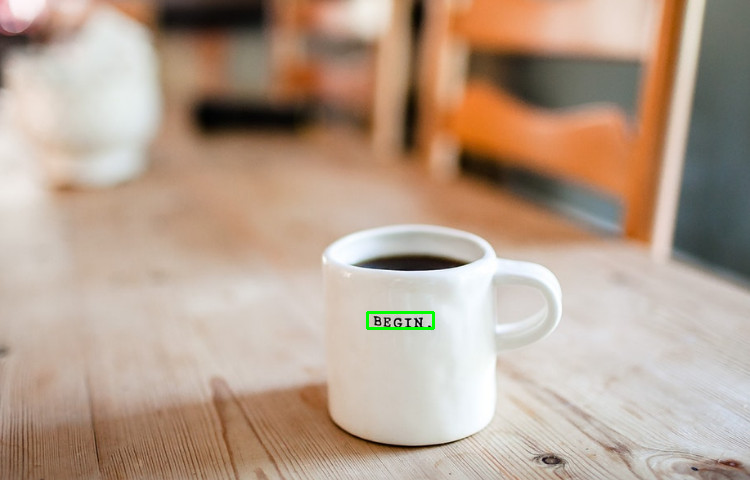

In [14]:
import cv2
import numpy as np
from imutils.object_detection import non_max_suppression
import pytesseract

detector = '/content/frozen_east_text_detection.pb'
width, height = 320, 320
image = cv2.imread('/content/cup.jpg')
min_confidence = 0.5

original = image.copy()
orig_H, orig_W = image.shape[:2]
proportion_w = orig_W / float(width)
proportion_h = orig_H / float(height)

# Resize for model
img = cv2.resize(image, (width, height))
H, W = img.shape[:2]

layer_names = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

# Load EAST model
net = cv2.dnn.readNet(detector)

# Create blob
blob = cv2.dnn.blobFromImage(
    img, 1.0, (W, H),
    (123.68, 116.78, 103.94),
    swapRB=True, crop=False
)
net.setInput(blob)
scores, geometry = net.forward(layer_names)

def geometric_data(geometry, y):
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    angles_data = geometry[0, 4, y]
    return angles_data, xData0, xData1, xData2, xData3

def geometric_calculation(x, y, angles_data, xData0, xData1, xData2, xData3):
    offsetX, offsetY = (x * 4.0, y * 4.0)
    angle = angles_data[x]
    cos = np.cos(angle)
    sin = np.sin(angle)

    h = xData0[x] + xData2[x]
    w = xData1[x] + xData3[x]

    endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
    endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
    beginX = int(endX - w)
    beginY = int(endY - h)

    return beginX, beginY, endX, endY

rows, cols = scores.shape[2:4]
boxes = []
confidences = []

for y in range(rows):
    data_scores = scores[0, 0, y]
    angles_data, xData0, xData1, xData2, xData3 = geometric_data(geometry, y)

    for x in range(cols):
        if data_scores[x] < min_confidence:
            continue
        box = geometric_calculation(x, y, angles_data, xData0, xData1, xData2, xData3)
        boxes.append(box)
        confidences.append(float(data_scores[x]))

# Apply non-max suppression
detections = non_max_suppression(np.array(boxes), probs=confidences)

# Draw
img_copy = original.copy()
for (beginx, beginy, endx, endy) in detections:
    beginx = int(beginx * proportion_w)
    beginy = int(beginy * proportion_h)
    endx = int(endx * proportion_w)
    endy = int(endy * proportion_h)

    # Crop detected text region
    roi = original[beginy:endy, beginx:endx]

    # Convert to RGB (pytesseract expects RGB or grayscale)
    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

     # OCR
    config_tesseract = '--tessdata-dir tessdata'
    text = pytesseract.image_to_string(roi_rgb,lang='eng',config=config_tesseract)
    print("Detected text:", text.strip())

    cv2.rectangle(img_copy, (beginx, beginy), (endx, endy), (0, 255, 0), 2)

cv2_imshow(img_copy)
